In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Generate sample driver data
np.random.seed(42)  # For reproducibility

# Define parameters
num_drivers = 100
num_weeks = 24  # 2 months of data
start_date = datetime(2024, 8, 1)

# Initialize driver metadata
driver_ids = [f"D{i:03d}" for i in range(1, num_drivers + 1)]
driver_ratings = np.random.uniform(3.0, 5.0, num_drivers).round(1)
driver_experience = np.random.randint(1, 36, num_drivers)  # Months of experience

# Create ride data
rides = []
for week in range(num_weeks):
    week_start = start_date + timedelta(days=week*7)
    
    for driver_id in driver_ids:
        # Number of ride requests per driver varies per week
        num_requests = np.random.randint(20, 50)
        
        for i in range(num_requests):
            ride_datetime = week_start + timedelta(
                days=np.random.randint(0, 7),
                hours=np.random.randint(0, 24),
                minutes=np.random.randint(0, 60)
            )
            
            # Determine if peak hour (7-9am, 5-7pm on weekdays)
            is_weekday = ride_datetime.weekday() < 5
            hour = ride_datetime.hour
            is_peak = is_weekday and ((7 <= hour < 9) or (17 <= hour < 19))
            
            # Determine ride distance and expected duration
            distance_km = np.random.exponential(8) + 2  # Min 2km ride
            expected_duration_min = (distance_km * 2) + np.random.uniform(5, 15)  # Base time plus traffic variation
            
            # Calculate base fare
            base_fare = 5 + (distance_km * 1.5)
            if is_peak:
                base_fare *= 1.3  # 30% surge during peak
            
            # Generate acceptance/cancellation behavior
            # Drivers are more likely to reject long rides or non-peak rides
            difficult_ride = distance_km > 15
            acceptance_prob = 0.9  # Base probability
            
            # Adjust probability based on ride characteristics
            if difficult_ride:
                acceptance_prob -= 0.2
            if not is_peak:
                acceptance_prob -= 0.1
            
            # Some drivers are just less reliable
            driver_reliability = np.random.uniform(0.7, 1.0)
            acceptance_prob *= driver_reliability
            
            # Final decision
            accepted = np.random.random() < acceptance_prob
            
            if accepted:
                cancellation_prob = 0.1  # Base cancellation probability
                if difficult_ride:
                    cancellation_prob += 0.1
                
                cancelled = np.random.random() < cancellation_prob
                if cancelled:
                    cancellation_reason = np.random.choice([
                        "Too far", "Traffic", "Vehicle issue", "Personal emergency", 
                        "Found better ride", "No reason provided"
                    ], p=[0.25, 0.2, 0.15, 0.1, 0.2, 0.1])
                else:
                    cancellation_reason = None
            else:
                cancelled = False
                cancellation_reason = None
            
            rides.append({
                "ride_id": f"R{len(rides) + 1:06d}",
                "driver_id": driver_id,
                "datetime": ride_datetime,
                "week_number": week + 1,
                "is_peak": is_peak,
                "distance_km": round(distance_km, 2),
                "expected_duration_min": round(expected_duration_min, 1),
                "base_fare": round(base_fare, 2),
                "ride_accepted": accepted,
                "ride_cancelled": cancelled,
                "cancellation_reason": cancellation_reason,
                "is_difficult_ride": difficult_ride
            })

# Create DataFrame
rides_df = pd.DataFrame(rides)

In [2]:
rides_df.head()

,ride_id,driver_id,datetime,week_number,is_peak,distance_km,expected_duration_min,base_fare,ride_accepted,ride_cancelled,cancellation_reason,is_difficult_ride
0,R000001,D001,2024-08-06 23:32:00,1,False,10.22,26.3,20.33,False,False,None,False
1,R000002,D001,2024-08-04 02:47:00,1,False,2.86,17.3,9.28,True,False,None,False
2,R000003,D001,2024-08-06 02:15:00,1,False,43.56,93.9,70.34,False,False,None,True
3,R000004,D001,2024-08-04 23:07:00,1,False,17.14,45.8,30.70,True,False,None,True
4,R000005,D001,2024-08-07 21:45:00,1,False,9.13,33.0,18.70,False,False,None,False


In [3]:
rides_df.to_csv("rides.csv", index=False)

In [4]:

# Create driver metadata DataFrame
drivers_df = pd.DataFrame({
    "driver_id": driver_ids,
    "rating": driver_ratings,
    "experience_months": driver_experience,
})


This function computes **weekly acceptance scores** for drivers based on their ride requests and cancellations.

In [5]:

# Function to calculate weekly acceptance scores
def calculate_acceptance_scores(rides_df):
    # Group by driver and week
    weekly_stats = rides_df.groupby(['driver_id', 'week_number']).agg(
        total_requests=('ride_id', 'count'),
        accepted_rides=('ride_accepted', 'sum'),
        cancelled_rides=('ride_cancelled', 'sum'),
        peak_rides_accepted=pd.NamedAgg(column='ride_accepted', 
                                       aggfunc=lambda x: ((rides_df['is_peak'] == True) & 
                                                         (x == True)).sum()),
        difficult_rides_accepted=pd.NamedAgg(column='ride_accepted', 
                                            aggfunc=lambda x: ((rides_df['is_difficult_ride'] == True) & 
                                                              (x == True)).sum())
    ).reset_index()
    
    # Calculate raw acceptance score (accepted / total)
    weekly_stats['raw_acceptance_score'] = weekly_stats['accepted_rides'] / weekly_stats['total_requests']
    
    # Calculate effective acceptance score (penalize cancellations)
    weekly_stats['effective_acceptance_score'] = (weekly_stats['accepted_rides'] - weekly_stats['cancelled_rides']) / weekly_stats['total_requests']
    
    # Handle edge cases where score might be negative
    weekly_stats['effective_acceptance_score'] = weekly_stats['effective_acceptance_score'].clip(0, 1)
    
    return weekly_stats

# Calculate weekly stats
weekly_stats = calculate_acceptance_scores(rides_df)

# Display results
print(weekly_stats)


     driver_id  week_number  total_requests  accepted_rides  cancelled_rides  \
0         D001            1              39              27                3   
1         D001            2              35              24                1   
2         D001            3              38              25                3   
3         D001            4              39              25                2   
4         D001            5              31              21                1   
...        ...          ...             ...             ...              ...   
2395      D100           20              26              14                1   
2396      D100           21              41              28                3   
2397      D100           22              20              11                1   
2398      D100           23              38              26                3   
2399      D100           24              48              28                3   

      peak_rides_accepted  difficult_ri

This function applies a **decay factor** to historical driver scores so that **older weeks have less impact** on the final score.


In [6]:

# Define decay factor function
def apply_decay_factor(driver_scores, decay_factor=0.85):
    """
    Apply a decay factor to historical scores so older weeks have less impact
    decay_factor: value between 0-1, how much to value previous week's score
    """
    # Initialize with first week's scores
    all_drivers = driver_scores['driver_id'].unique()
    all_weeks = sorted(driver_scores['week_number'].unique())
    
    # Create result dataframe structure
    result = []
    
    for driver_id in all_drivers:
        driver_data = driver_scores[driver_scores['driver_id'] == driver_id].sort_values('week_number')
        
        # Process each week
        cumulative_score = 0
        cumulative_weight = 0
        
        for _, week_data in driver_data.iterrows():
            week_num = week_data['week_number']
            
            # Current week's raw score
            raw_score = week_data['effective_acceptance_score']
            
            # Apply decay to cumulative score from previous weeks
            if cumulative_weight > 0:
                cumulative_score = cumulative_score * decay_factor
                cumulative_weight = cumulative_weight * decay_factor
            
            # Add current week with weight 1
            cumulative_score += raw_score
            cumulative_weight += 1
            
            # Calculate decayed score
            decayed_score = cumulative_score / cumulative_weight
            
            result.append({
                'driver_id': driver_id,
                'week_number': week_num,
                'raw_score': raw_score,
                'decayed_score': decayed_score
            })
    
    return pd.DataFrame(result)

# Apply Decay Factor
decayed_scores = apply_decay_factor(weekly_stats)

# Merge with weekly_stats
weekly_stats = weekly_stats.merge(
    decayed_scores[['driver_id', 'week_number', 'decayed_score']], 
    on=['driver_id', 'week_number']
)

# Display results
print(weekly_stats)

     driver_id  week_number  total_requests  accepted_rides  cancelled_rides  \
0         D001            1              39              27                3   
1         D001            2              35              24                1   
2         D001            3              38              25                3   
3         D001            4              39              25                2   
4         D001            5              31              21                1   
...        ...          ...             ...             ...              ...   
2395      D100           20              26              14                1   
2396      D100           21              41              28                3   
2397      D100           22              20              11                1   
2398      D100           23              38              26                3   
2399      D100           24              48              28                3   

      peak_rides_accepted  difficult_ri

This function resets driver acceptance scores **every 8 weeks** (bi-monthly). It ensures **past performance does not permanently affect drivers** by periodically resetting scores.


In [7]:
# Define a function to reset scores every 2 months (8 weeks)
def reset_scores_bimonthly(scores_df, reset_period=8):
    """Reset scores every specified period (in weeks)"""
    reset_scores = scores_df.copy()
    
    # Create a period column (1-based)
    reset_scores['period'] = ((reset_scores['week_number'] - 1) // reset_period) + 1
    
    # Group by driver and period to get the period's score
    driver_periods = reset_scores.groupby(['driver_id', 'period']).agg(
        min_week=('week_number', 'min'),
        max_week=('week_number', 'max'),
        period_score=('decayed_score', 'last')
    ).reset_index()
    
    # Merge back with original data
    result = reset_scores.merge(
        driver_periods[['driver_id', 'period', 'period_score']], 
        on=['driver_id', 'period']
    )
    
    # For the first week of each period, score is 0 (reset)
    result['is_reset_week'] = result['week_number'] % reset_period == 1
    result['final_score'] = np.where(result['is_reset_week'], 0, result['decayed_score'])
    
    return result

# Apply bimonthly resets
driver_scores = reset_scores_bimonthly(weekly_stats)
print(driver_scores)

     driver_id  week_number  total_requests  accepted_rides  cancelled_rides  \
0         D001            1              39              27                3   
1         D001            2              35              24                1   
2         D001            3              38              25                3   
3         D001            4              39              25                2   
4         D001            5              31              21                1   
...        ...          ...             ...             ...              ...   
2395      D100           20              26              14                1   
2396      D100           21              41              28                3   
2397      D100           22              20              11                1   
2398      D100           23              38              26                3   
2399      D100           24              48              28                3   

      peak_rides_accepted  difficult_ri

This function calculates **incentives** for drivers based on their **acceptance scores** and performance in **peak-hour and difficult rides**.


In [8]:

# Define incentive calculation function
def calculate_incentives(driver_scores, rides_df):
    """
    Calculate incentives based on:
    1. Low acceptance score drivers get higher incentives for accepting peak/difficult rides
    2. High acceptance score drivers get prioritized for normal rides
    """
    # Get the latest scores for each driver
    latest_scores = driver_scores.sort_values('week_number').groupby('driver_id').last().reset_index()
    
    # Define incentive parameters
    base_incentive = 50  # Base incentive amount
    peak_bonus = 20      # Additional bonus for peak rides
    difficult_bonus = 15 # Additional bonus for difficult rides
    
    # Define acceptance score thresholds
    low_score_threshold = 0.7
    
    # Calculate incentives
    incentives = []
    
    for _, driver in latest_scores.iterrows():
        driver_id = driver['driver_id']
        acceptance_score = driver['final_score']
        
        # Get driver's rides for the last week
        driver_last_week = driver['week_number']
        driver_rides = rides_df[(rides_df['driver_id'] == driver_id) & 
                               (rides_df['week_number'] == driver_last_week)]
        
        # Calculate rewards based on acceptance patterns
        if acceptance_score < low_score_threshold:
            # Low acceptance score: higher incentives for peak/difficult rides
            peak_incentive = peak_bonus * 1.5
            difficult_incentive = difficult_bonus * 1.5
        else:
            # High acceptance score: normal incentives
            peak_incentive = peak_bonus
            difficult_incentive = difficult_bonus
        
        # Count accepted peak and difficult rides
        peak_rides = driver_rides[(driver_rides['is_peak']) & 
                                (driver_rides['ride_accepted']) & 
                                (~driver_rides['ride_cancelled'])].shape[0]
        
        difficult_rides = driver_rides[(driver_rides['is_difficult_ride']) & 
                                     (driver_rides['ride_accepted']) & 
                                     (~driver_rides['ride_cancelled'])].shape[0]
        
        # Calculate total incentive
        total_incentive = base_incentive + (peak_rides * peak_incentive) + (difficult_rides * difficult_incentive)
        
        # Special bonuses for drivers with high acceptance scores
        if acceptance_score > 0.9:
            total_incentive *= 1.1  # 10% bonus
            rewards_tier = "Gold"
            fuel_discount = "10%"
        elif acceptance_score > 0.8:
            total_incentive *= 1.05  # 5% bonus
            rewards_tier = "Silver"
            fuel_discount = "7%"
        else:
            rewards_tier = "Bronze"
            fuel_discount = "5%"
        
        incentives.append({
            'driver_id': driver_id,
            'week_number': driver_last_week,
            'acceptance_score': acceptance_score,
            'peak_rides_completed': peak_rides,
            'difficult_rides_completed': difficult_rides,
            'incentive_amount': round(total_incentive, 2),
            'rewards_tier': rewards_tier,
            'fuel_discount': fuel_discount
        })
    
    return pd.DataFrame(incentives)

# Calculate incentives
incentives = calculate_incentives(driver_scores, rides_df)
print(incentives)


   driver_id  week_number  acceptance_score  peak_rides_completed  \
0       D001           24          0.563640                     1   
1       D002           24          0.565572                     2   
2       D003           24          0.555455                     6   
3       D004           24          0.609593                     4   
4       D005           24          0.596879                     6   
..       ...          ...               ...                   ...   
95      D096           24          0.593118                     6   
96      D097           24          0.592185                     4   
97      D098           24          0.576709                     1   
98      D099           24          0.592428                     3   
99      D100           24          0.567311                     4   

    difficult_rides_completed  incentive_amount rewards_tier fuel_discount  
0                           4             170.0       Bronze            5%  
1                

In [18]:
incentives.to_csv("incentives.csv", index=False)

This function analyzes **driver rejection and cancellation behaviors**, identifying **high-rejection drivers** and the most common **cancellation reasons**.


In [9]:

# Create a function to analyze rejection patterns
def analyze_rejection_patterns(rides_df):
    """Analyze patterns of ride rejections and cancellations"""
    
    # Calculate rejection rates by driver
    driver_rejections = rides_df.groupby('driver_id').agg(
        total_requests=('ride_id', 'count'),
        rejections=pd.NamedAgg(column='ride_accepted', aggfunc=lambda x: (~x).sum()),
        cancellations=('ride_cancelled', 'sum'),
    ).reset_index()
    
    driver_rejections['rejection_rate'] = driver_rejections['rejections'] / driver_rejections['total_requests']
    driver_rejections['cancellation_rate'] = driver_rejections['cancellations'] / driver_rejections['total_requests']
    
    # Find drivers with high rejection rates
    high_rejection_drivers = driver_rejections[driver_rejections['rejection_rate'] > 0.25]
    
    # Analyze rejection reasons for these drivers
    if not rides_df[~rides_df['ride_accepted']].empty:
        # Analyze properties of rejected rides
        rejected_rides = rides_df[~rides_df['ride_accepted']]
        
        rejection_analysis = rejected_rides.groupby('driver_id').agg(
            avg_distance=('distance_km', 'mean'),
            peak_rejection_rate=pd.NamedAgg(column='is_peak', 
                                          aggfunc=lambda x: (~x).mean()),
            difficult_rejection_rate=pd.NamedAgg(column='is_difficult_ride', 
                                               aggfunc=lambda x: x.mean())
        ).reset_index()
        
        high_rejection_drivers = high_rejection_drivers.merge(
            rejection_analysis, on='driver_id', how='left'
        )
    
    # Analyze cancellation reasons
    cancellation_reasons = rides_df[rides_df['ride_cancelled']].groupby(
        ['driver_id', 'cancellation_reason']).size().reset_index(name='count')
    
    return high_rejection_drivers, cancellation_reasons

# Analyze rejection patterns
high_rejection_drivers, cancellation_reasons = analyze_rejection_patterns(rides_df)
print(high_rejection_drivers, cancellation_reasons)

   driver_id  total_requests  rejections  cancellations  rejection_rate  \
0       D001             890         328             62        0.368539   
1       D002             789         260             50        0.329531   
2       D003             915         320             72        0.349727   
3       D004             831         272             63        0.327316   
4       D005             786         267             58        0.339695   
..       ...             ...         ...            ...             ...   
95      D096             832         277             64        0.332933   
96      D097             809         261             79        0.322621   
97      D098             861         297             74        0.344948   
98      D099             860         284             72        0.330233   
99      D100             850         285             55        0.335294   

    cancellation_rate  avg_distance  peak_rejection_rate  \
0            0.069663     11.694756    

In [13]:
print(driver_scores['driver_id'].unique())  # Check available driver IDs

['D001' 'D002' 'D003' 'D004' 'D005' 'D006' 'D007' 'D008' 'D009' 'D010'
 'D011' 'D012' 'D013' 'D014' 'D015' 'D016' 'D017' 'D018' 'D019' 'D020'
 'D021' 'D022' 'D023' 'D024' 'D025' 'D026' 'D027' 'D028' 'D029' 'D030'
 'D031' 'D032' 'D033' 'D034' 'D035' 'D036' 'D037' 'D038' 'D039' 'D040'
 'D041' 'D042' 'D043' 'D044' 'D045' 'D046' 'D047' 'D048' 'D049' 'D050'
 'D051' 'D052' 'D053' 'D054' 'D055' 'D056' 'D057' 'D058' 'D059' 'D060'
 'D061' 'D062' 'D063' 'D064' 'D065' 'D066' 'D067' 'D068' 'D069' 'D070'
 'D071' 'D072' 'D073' 'D074' 'D075' 'D076' 'D077' 'D078' 'D079' 'D080'
 'D081' 'D082' 'D083' 'D084' 'D085' 'D086' 'D087' 'D088' 'D089' 'D090'
 'D091' 'D092' 'D093' 'D094' 'D095' 'D096' 'D097' 'D098' 'D099' 'D100']


This function **visualizes the performance** of a specific driver, showing:
1. **Weekly acceptance scores** (Raw, Decayed, and Final with resets).
2. **Incentives and ride statistics** (Peak & Difficult rides).

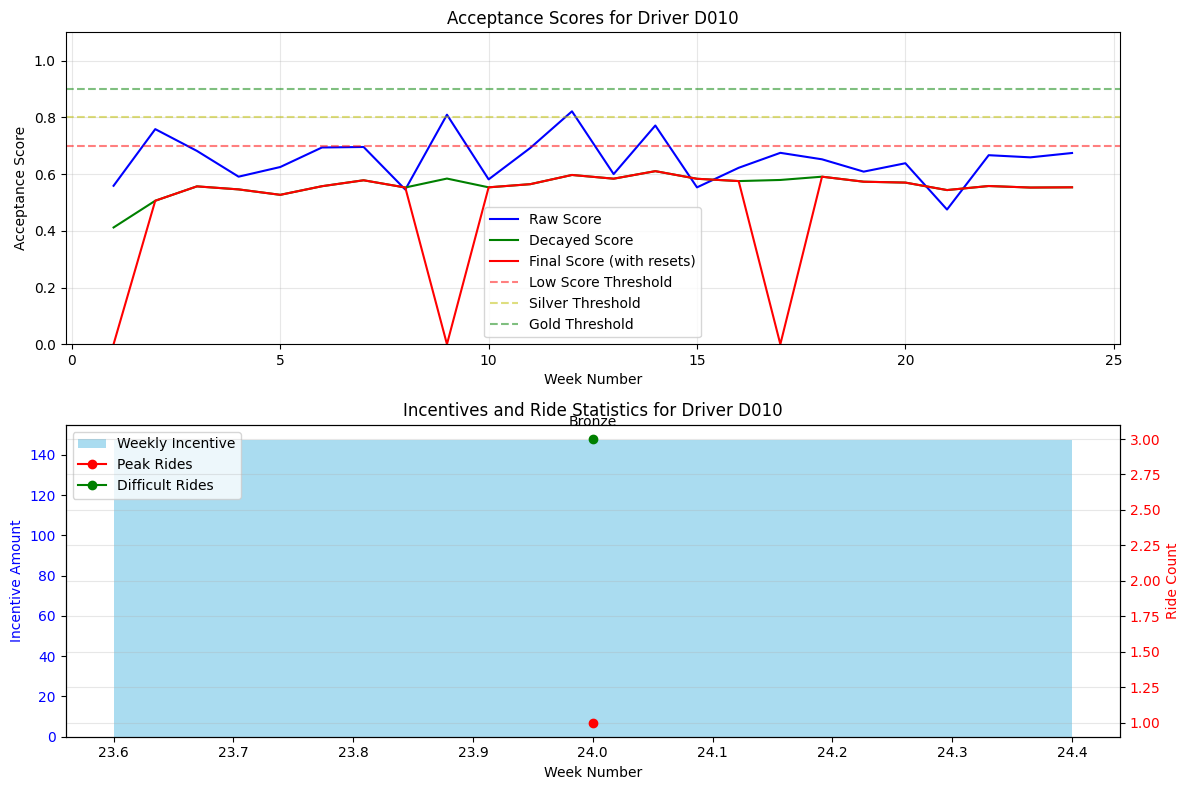

In [14]:
import matplotlib.pyplot as plt

def plot_driver_performance(driver_scores, incentives, driver_id):
    """Plot performance metrics for a specific driver"""
    
    driver_data = driver_scores[driver_scores['driver_id'] == driver_id]
    driver_incentives = incentives[incentives['driver_id'] == driver_id]
    
    plt.figure(figsize=(12, 8))
    
    # Plot weekly acceptance scores
    plt.subplot(2, 1, 1)
    plt.plot(driver_data['week_number'], driver_data['raw_acceptance_score'], 'b-', label='Raw Score')
    plt.plot(driver_data['week_number'], driver_data['decayed_score'], 'g-', label='Decayed Score')
    plt.plot(driver_data['week_number'], driver_data['final_score'], 'r-', label='Final Score (with resets)')
    
    plt.axhline(y=0.7, color='r', linestyle='--', alpha=0.5, label='Low Score Threshold')
    plt.axhline(y=0.8, color='y', linestyle='--', alpha=0.5, label='Silver Threshold')
    plt.axhline(y=0.9, color='g', linestyle='--', alpha=0.5, label='Gold Threshold')
    
    plt.title(f'Acceptance Scores for Driver {driver_id}')
    plt.xlabel('Week Number')
    plt.ylabel('Acceptance Score')
    plt.ylim(0, 1.1)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot incentives and ride statistics
    plt.subplot(2, 1, 2)
    
    # Primary axis for incentive amount
    ax1 = plt.gca()
    ax1.bar(driver_incentives['week_number'], driver_incentives['incentive_amount'], 
            color='skyblue', alpha=0.7, label='Weekly Incentive')
    ax1.set_xlabel('Week Number')
    ax1.set_ylabel('Incentive Amount', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Secondary axis for ride counts
    ax2 = ax1.twinx()
    ax2.plot(driver_incentives['week_number'], driver_incentives['peak_rides_completed'], 
             'ro-', label='Peak Rides')
    ax2.plot(driver_incentives['week_number'], driver_incentives['difficult_rides_completed'], 
             'go-', label='Difficult Rides')
    ax2.set_ylabel('Ride Count', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add the reward tier as text annotation
    for i, row in driver_incentives.iterrows():
        ax1.annotate(row['rewards_tier'], 
                    xy=(row['week_number'], row['incentive_amount']),
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.title(f'Incentives and Ride Statistics for Driver {driver_id}')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return plt

# Plot driver performance
plt = plot_driver_performance(driver_scores, incentives, driver_id="D010")
plt.show()


In [19]:
driver_scores.to_csv("driver_scores.csv", index=False)

In [36]:
print(driver_scores.columns)


Index(['driver_id', 'week_number', 'total_requests', 'accepted_rides',
       'cancelled_rides', 'peak_rides_accepted', 'difficult_rides_accepted',
       'raw_acceptance_score', 'effective_acceptance_score', 'decayed_score',
       'period', 'period_score', 'is_reset_week', 'final_score'],
      dtype='object')


This function **visualizes ride rejection patterns** for a specific driver, helping to analyze:
1. **How often they reject rides**.
2. **What types of rides they reject most**.
3. **Why they cancel rides**.

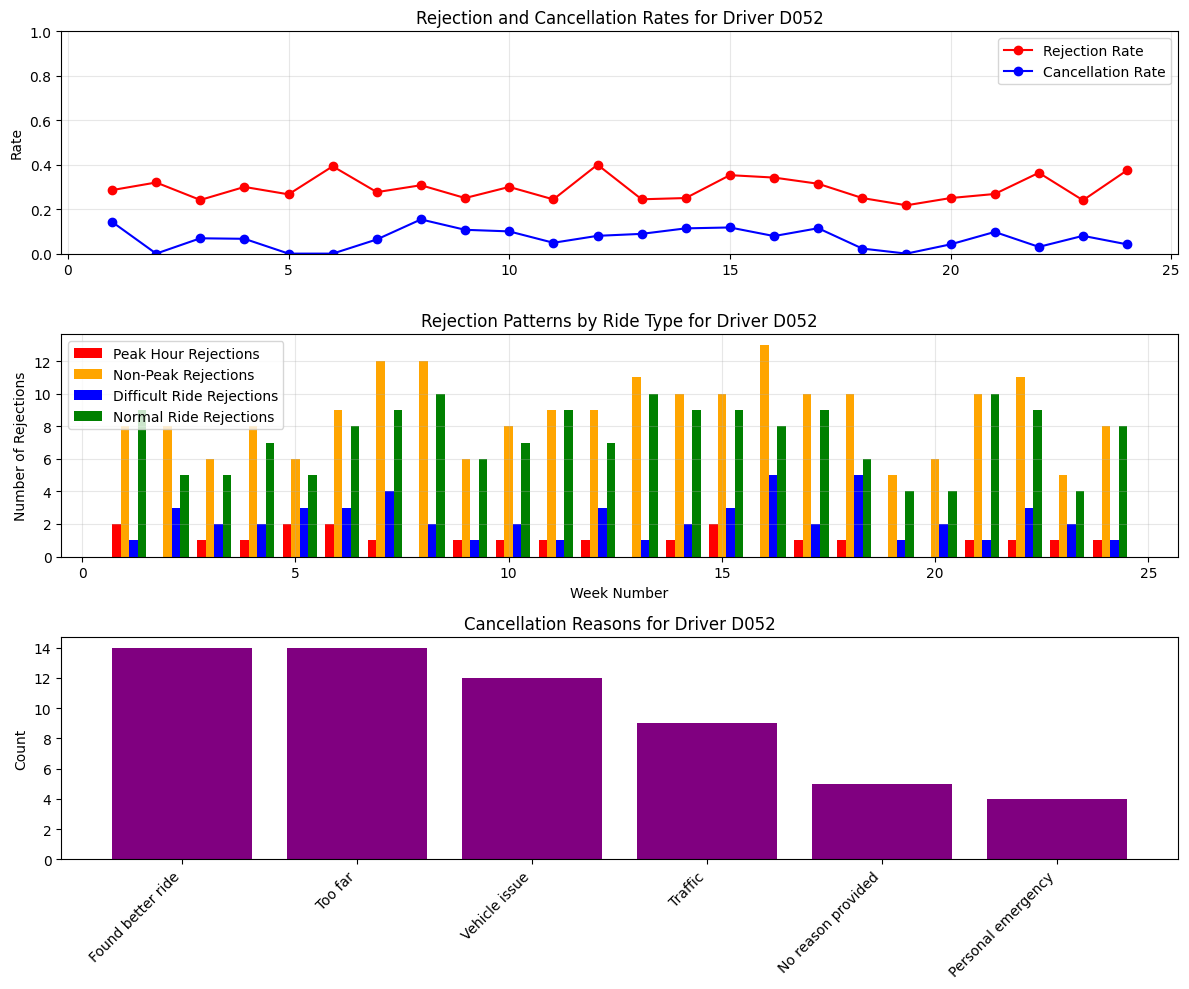

In [15]:

# Function to plot rejection patterns for a driver
def plot_driver_rejections(rides_df, driver_id):
    """Plot detailed rejection patterns for a specific driver"""
    
    # Filter data for the specified driver
    driver_rides = rides_df[rides_df['driver_id'] == driver_id]
    
    # Count rejections and cancellations by week
    weekly_rejections = driver_rides.groupby('week_number').agg(
        total_requests=('ride_id', 'count'),
        accepted=('ride_accepted', 'sum'),
        rejected=pd.NamedAgg(column='ride_accepted', aggfunc=lambda x: (~x).sum()),
        cancelled=('ride_cancelled', 'sum')
    ).reset_index()
    
    # Calculate rates
    weekly_rejections['rejection_rate'] = weekly_rejections['rejected'] / weekly_rejections['total_requests']
    weekly_rejections['cancellation_rate'] = weekly_rejections['cancelled'] / weekly_rejections['total_requests']
    
    # Plot the data
    plt.figure(figsize=(12, 10))
    
    # Plot rejection and cancellation rates
    plt.subplot(3, 1, 1)
    plt.plot(weekly_rejections['week_number'], weekly_rejections['rejection_rate'], 'r-o', label='Rejection Rate')
    plt.plot(weekly_rejections['week_number'], weekly_rejections['cancellation_rate'], 'b-o', label='Cancellation Rate')
    plt.title(f'Rejection and Cancellation Rates for Driver {driver_id}')
    plt.ylabel('Rate')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot rejection patterns by ride characteristics
    plt.subplot(3, 1, 2)
    
    # Analyze rejections by ride characteristics
    peak_rejections = driver_rides[~driver_rides['ride_accepted'] & driver_rides['is_peak']].groupby('week_number').size()
    nonpeak_rejections = driver_rides[~driver_rides['ride_accepted'] & ~driver_rides['is_peak']].groupby('week_number').size()
    difficult_rejections = driver_rides[~driver_rides['ride_accepted'] & driver_rides['is_difficult_ride']].groupby('week_number').size()
    normal_rejections = driver_rides[~driver_rides['ride_accepted'] & ~driver_rides['is_difficult_ride']].groupby('week_number').size()
    
    # Get all weeks for proper plotting
    all_weeks = driver_rides['week_number'].unique()
    
    # Convert series to dataframe with all weeks
    peak_df = pd.DataFrame(index=all_weeks).join(peak_rejections.rename('count')).fillna(0)
    nonpeak_df = pd.DataFrame(index=all_weeks).join(nonpeak_rejections.rename('count')).fillna(0)
    difficult_df = pd.DataFrame(index=all_weeks).join(difficult_rejections.rename('count')).fillna(0)
    normal_df = pd.DataFrame(index=all_weeks).join(normal_rejections.rename('count')).fillna(0)
    
    # Plot
    plt.bar(all_weeks - 0.2, peak_df['count'], width=0.2, color='red', label='Peak Hour Rejections')
    plt.bar(all_weeks, nonpeak_df['count'], width=0.2, color='orange', label='Non-Peak Rejections')
    plt.bar(all_weeks + 0.2, difficult_df['count'], width=0.2, color='blue', label='Difficult Ride Rejections')
    plt.bar(all_weeks + 0.4, normal_df['count'], width=0.2, color='green', label='Normal Ride Rejections')
    
    plt.title(f'Rejection Patterns by Ride Type for Driver {driver_id}')
    plt.xlabel('Week Number')
    plt.ylabel('Number of Rejections')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot cancellation reasons if any
    plt.subplot(3, 1, 3)
    
    if driver_rides['ride_cancelled'].sum() > 0:
        cancellation_counts = driver_rides[driver_rides['ride_cancelled']].groupby(
            ['cancellation_reason']).size().sort_values(ascending=False)
        
        plt.bar(range(len(cancellation_counts)), cancellation_counts.values, color='purple')
        plt.xticks(range(len(cancellation_counts)), cancellation_counts.index, rotation=45, ha='right')
        plt.title(f'Cancellation Reasons for Driver {driver_id}')
        plt.ylabel('Count')
        plt.tight_layout()
    else:
        plt.text(0.5, 0.5, 'No cancellations for this driver', 
                 horizontalalignment='center', verticalalignment='center')
        plt.title(f'Cancellation Reasons for Driver {driver_id}')
        plt.axis('off')
    
    plt.tight_layout()
    return plt

plt = plot_driver_rejections(rides_df, driver_id="D052")
plt.show()

This function **generates a full performance analysis** for a driver, including:
1. **Acceptance rates & cancellation trends**.
2. **Rejection behavior for peak & difficult rides**.
3. **Visualizations of scores & rejection patterns**.

In [16]:


# Example usage for both functions
def analyze_driver(driver_scores, incentives, rides_df, driver_id):
    """Generate comprehensive analysis for a specific driver"""
    
    # Generate performance charts
    perf_chart = plot_driver_performance(driver_scores, incentives, driver_id)
    perf_chart.savefig(f"driver_{driver_id}_performance.png")
    
    # Generate rejection analysis
    rej_chart = plot_driver_rejections(rides_df, driver_id)
    rej_chart.savefig(f"driver_{driver_id}_rejections.png")
    
    # Calculate summary statistics
    driver_data = rides_df[rides_df['driver_id'] == driver_id]
    
    total_requests = len(driver_data)
    acceptance_rate = driver_data['ride_accepted'].mean()
    cancellation_rate = driver_data['ride_cancelled'].sum() / len(driver_data)
    
    # Calculate statistics for different ride types
    peak_acceptance = driver_data[driver_data['is_peak']]['ride_accepted'].mean()
    difficult_acceptance = driver_data[driver_data['is_difficult_ride']]['ride_accepted'].mean()
    
    print(f"Driver {driver_id} Analysis:")
    print(f"Total Ride Requests: {total_requests}")
    print(f"Overall Acceptance Rate: {acceptance_rate:.2%}")
    print(f"Cancellation Rate: {cancellation_rate:.2%}")
    print(f"Peak Hour Acceptance Rate: {peak_acceptance:.2%}")
    print(f"Difficult Ride Acceptance Rate: {difficult_acceptance:.2%}")
    
    # Find this driver in high rejection drivers if applicable
    if driver_id in high_rejection_drivers['driver_id'].values:
        driver_rejection_data = high_rejection_drivers[high_rejection_drivers['driver_id'] == driver_id]
        print("\nHigh Rejection Driver Alert:")
        print(f"Rejection Rate: {driver_rejection_data['rejection_rate'].values[0]:.2%}")
        print(f"Average Distance of Rejected Rides: {driver_rejection_data['avg_distance'].values[0]:.2f} km")
        print(f"Rejection Rate for Peak Hours: {driver_rejection_data['peak_rejection_rate'].values[0]:.2%}")
        print(f"Rejection Rate for Difficult Rides: {driver_rejection_data['difficult_rejection_rate'].values[0]:.2%}")
    
    print("\nPlots saved as:")
    print(f"- driver_{driver_id}_performance.png")
    print(f"- driver_{driver_id}_rejections.png")
    
    plt.close('all')  # Close plots to free memory
    
    return {
        'driver_id': driver_id,
        'total_requests': total_requests,
        'acceptance_rate': acceptance_rate,
        'cancellation_rate': cancellation_rate,
        'peak_acceptance': peak_acceptance,
        'difficult_acceptance': difficult_acceptance,
        'high_rejection': driver_id in high_rejection_drivers['driver_id'].values
    }

# Example call to analyze a specific driver
print(analyze_driver(driver_scores, incentives, rides_df, "D001"))


Driver D001 Analysis:
Total Ride Requests: 890
Overall Acceptance Rate: 63.15%
Cancellation Rate: 6.97%
Peak Hour Acceptance Rate: 73.47%
Difficult Ride Acceptance Rate: 49.47%

High Rejection Driver Alert:
Rejection Rate: 36.85%
Average Distance of Rejected Rides: 11.69 km
Rejection Rate for Peak Hours: 92.07%
Rejection Rate for Difficult Rides: 28.96%

Plots saved as:
- driver_D001_performance.png
- driver_D001_rejections.png
{'driver_id': 'D001', 'total_requests': 890, 'acceptance_rate': 0.6314606741573033, 'cancellation_rate': 0.0696629213483146, 'peak_acceptance': 0.7346938775510204, 'difficult_acceptance': 0.4946808510638298, 'high_rejection': True}



This function identifies **top N problem drivers** who have **high rejection rates**, analyzes their **performance, ride acceptance, and rejection behavior**, and generates detailed reports.


In [17]:

# To analyze multiple drivers
def analyze_top_problem_drivers(driver_scores, incentives, rides_df, n=5):
    """Analyze top N drivers with acceptance issues"""
    # Identify top problem drivers
    problem_drivers = high_rejection_drivers.sort_values('rejection_rate', ascending=False)['driver_id'].head(n)
    
    results = []
    for driver_id in problem_drivers:
        result = analyze_driver(driver_scores, incentives, rides_df, driver_id)
        results.append(result)
        print("\n" + "="*50 + "\n")
    
    return results

# Example call to analyze top problem drivers
top_driver_analysis = analyze_top_problem_drivers(driver_scores, incentives, rides_df)
print(top_driver_analysis)

Driver D041 Analysis:
Total Ride Requests: 843
Overall Acceptance Rate: 62.16%
Cancellation Rate: 7.95%
Peak Hour Acceptance Rate: 63.64%
Difficult Ride Acceptance Rate: 48.92%

High Rejection Driver Alert:
Rejection Rate: 37.84%
Average Distance of Rejected Rides: 11.46 km
Rejection Rate for Peak Hours: 88.71%
Rejection Rate for Difficult Rides: 29.78%

Plots saved as:
- driver_D041_performance.png
- driver_D041_rejections.png


Driver D073 Analysis:
Total Ride Requests: 814
Overall Acceptance Rate: 62.53%
Cancellation Rate: 5.77%
Peak Hour Acceptance Rate: 73.12%
Difficult Ride Acceptance Rate: 54.25%

High Rejection Driver Alert:
Rejection Rate: 37.47%
Average Distance of Rejected Rides: 10.95 km
Rejection Rate for Peak Hours: 91.80%
Rejection Rate for Difficult Rides: 22.95%

Plots saved as:
- driver_D073_performance.png
- driver_D073_rejections.png


Driver D016 Analysis:
Total Ride Requests: 829
Overall Acceptance Rate: 62.85%
Cancellation Rate: 7.24%
Peak Hour Acceptance Rate: 6

In [ ]:
function = calculate_acceptance_scores, apply_decay_factor, reset_scores_bimonthly, calculate_incentives, analyze_rejection_patterns, plot_driver_performance, plot_driver_rejections, analyze_driver, analyze_top_problem_drivers